In [1]:
from matplotlib import pyplot as plt

import argparse
import datetime
import json
import random
import time
from pathlib import Path
import os

import numpy as np
# import pandas as pd 
import torch
from torch.utils.data import DataLoader, DistributedSampler

import datasets
import util.misc as utils
from datasets import build_dataset, get_coco_api_from_dataset
from engine import evaluate, train_one_epoch
from models import build_model

from tqdm import tqdm

from utils import *

from dataset_algonauts import fetch_dataloader

from scipy.stats import pearsonr as corr

import code

100%|███████████████████████████████████████████████████████████████████████████| 20544/20544 [00:12<00:00, 1673.89it/s]
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


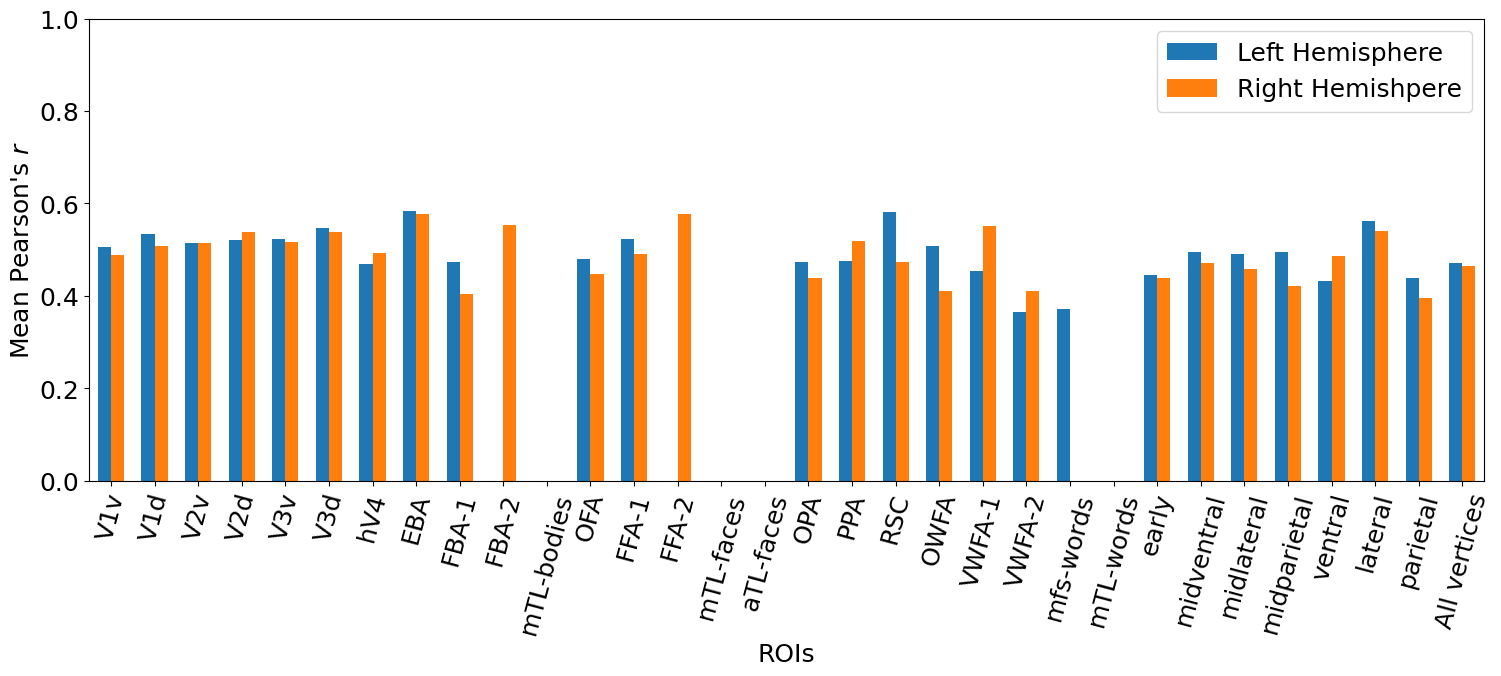

subj: 1   lh_corr: 0.4700725883843859   rh_corr: 0.4642575938358336
lh_corr_mean: 0.4700725883843859   rh_corr_mean: 0.4642575938358336


In [2]:
lh_corr = []
rh_corr = []

verbose = 1
plot_figs = 1 

data_dir = '../../algonauts_2023_challenge_data/'


for subj in [1]: # range(1,9):
    
    class argObj:
        def __init__(self, data_dir, subj):

            self.subj = format(subj, '02')
            self.data_dir = os.path.join(data_dir, 'subj'+self.subj)

    args = argObj(data_dir, subj)
    
    readout_res = 'streams_inc'  # [streams_inc', 'visuals', 'bodies', 'places', 'faces', 'words']
    run = 1  # range(1,11)
    lay = 1 # range(1,11)

    test_save_dir = '../results/detr_dino_'+ str(lay)+ '_' + readout_res + '_16/' + str(args.subj)  
    subj_res_dir = test_save_dir + '/run' + str(run) + '/'

    idxs = np.load(subj_res_dir + '/idxs.npy')  

    num_train = int(np.round(len(idxs) / 100 * 90))
    idxs_train, idxs_val = idxs[:num_train], idxs[num_train:]


    fmri_dir = os.path.join(args.data_dir, 'training_split', 'training_fmri')
    lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
    rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))



    lh_fmri_train = lh_fmri[idxs_train]
    lh_fmri_val = lh_fmri[idxs_val]
    rh_fmri_train = rh_fmri[idxs_train]
    rh_fmri_val = rh_fmri[idxs_val]

    lh_fmri_val_pred = np.load(subj_res_dir + 'lh_fmri_val_pred.npy')
    rh_fmri_val_pred = np.load(subj_res_dir + 'rh_fmri_val_pred.npy')

    # Empty correlation array of shape: (LH vertices)
    lh_correlation = np.zeros(lh_fmri_val_pred.shape[1])
    # Correlate each predicted LH vertex with the corresponding ground truth vertex
    for v in tqdm(range(lh_fmri_val_pred.shape[1])):
        lh_correlation[v] = corr(lh_fmri_val_pred[:,v], lh_fmri_val[:,v])[0]

    # Empty correlation array of shape: (RH vertices)
    rh_correlation = np.zeros(rh_fmri_val_pred.shape[1])
    # Correlate each predicted RH vertex with the corresponding ground truth vertex
    for v in tqdm(range(rh_fmri_val_pred.shape[1])):
        rh_correlation[v] = corr(rh_fmri_val_pred[:,v], rh_fmri_val[:,v])[0]

        hemisphere = 'left' #@param ['left', 'right'] {allow-input: true}

    # Load the brain surface map of all vertices
    roi_dir = os.path.join(args.data_dir, 'roi_masks',
        hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
    fsaverage_all_vertices = np.load(roi_dir)


    # Load the ROI classes mapping dictionaries
    roi_mapping_files = ['mapping_prf-visualrois.npy', 'mapping_floc-bodies.npy',
        'mapping_floc-faces.npy', 'mapping_floc-places.npy',
        'mapping_floc-words.npy', 'mapping_streams.npy']
    roi_name_maps = []
    for r in roi_mapping_files:
        roi_name_maps.append(np.load(os.path.join(args.data_dir, 'roi_masks', r),
            allow_pickle=True).item())

    # Load the ROI brain surface maps
    lh_challenge_roi_files = ['lh.prf-visualrois_challenge_space.npy',
        'lh.floc-bodies_challenge_space.npy', 'lh.floc-faces_challenge_space.npy',
        'lh.floc-places_challenge_space.npy', 'lh.floc-words_challenge_space.npy',
        'lh.streams_challenge_space.npy']
    rh_challenge_roi_files = ['rh.prf-visualrois_challenge_space.npy',
        'rh.floc-bodies_challenge_space.npy', 'rh.floc-faces_challenge_space.npy',
        'rh.floc-places_challenge_space.npy', 'rh.floc-words_challenge_space.npy',
        'rh.streams_challenge_space.npy']
    lh_challenge_rois = []
    rh_challenge_rois = []
    for r in range(len(lh_challenge_roi_files)):
        lh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
            lh_challenge_roi_files[r])))
        rh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
            rh_challenge_roi_files[r])))

    # Select the correlation results vertices of each ROI
    roi_names = []
    lh_roi_correlation = []
    rh_roi_correlation = []
    for r1 in range(len(lh_challenge_rois)):
        for r2 in roi_name_maps[r1].items():
            if r2[0] != 0: # zeros indicate to vertices falling outside the ROI of interest
                roi_names.append(r2[1])
                lh_roi_idx = np.where(lh_challenge_rois[r1] == r2[0])[0]
                rh_roi_idx = np.where(rh_challenge_rois[r1] == r2[0])[0]
                lh_roi_correlation.append(lh_correlation[lh_roi_idx])
                rh_roi_correlation.append(rh_correlation[rh_roi_idx])
    roi_names.append('All vertices')
    lh_roi_correlation.append(lh_correlation)
    rh_roi_correlation.append(rh_correlation)

    # Create the plot
    lh_mean_roi_correlation = [np.mean(np.nan_to_num(np.array(lh_roi_correlation[r]), copy=True, nan=0.0, posinf=None, neginf=None))
        for r in range(len(lh_roi_correlation))]
    rh_mean_roi_correlation = [np.mean(np.nan_to_num(np.array(rh_roi_correlation[r]), copy=True, nan=0.0, posinf=None, neginf=None))
        for r in range(len(rh_roi_correlation))]

    plt.rcParams.update({'font.size': 18})

    if plot_figs:
        fig = plt.figure(figsize=(18,6))
        x = np.arange(len(roi_names))
        width = 0.30
        plt.bar(x - width/2, lh_mean_roi_correlation, width, label='Left Hemisphere')
        plt.bar(x + width/2, rh_mean_roi_correlation, width,
            label='Right Hemishpere')
        plt.xlim(left=min(x)-.5, right=max(x)+.5)
        plt.ylim(bottom=0, top=1)
        plt.xlabel('ROIs')
        plt.xticks(ticks=x, labels=roi_names, rotation=75)
        plt.ylabel('Mean Pearson\'s $r$')
        plt.legend(frameon=True, loc=1);
        plt.show()
        
        #fig.savefig('figures/detr_dino_8_visuals_16.pdf', format='pdf', bbox_inches="tight")
        #fig.savefig('figures/detr_dino_1_streams_inc_16.jpg', dpi=300, bbox_inches="tight")

    lh_corr.append(lh_mean_roi_correlation[-1])
    rh_corr.append(rh_mean_roi_correlation[-1])

    if verbose:
        print(f'subj: {subj}   lh_corr: {lh_mean_roi_correlation[-1]}   rh_corr: {rh_mean_roi_correlation[-1]}')


if verbose:
    print(f'lh_corr_mean: {np.array(lh_corr).mean()}   rh_corr_mean: {np.array(rh_corr).mean()}')

/tmp/ipykernel_64382/251273020.py:48: RuntimeWarning: Mean of empty slice
  lh_fsaverage = np.nanmean(lh_fsaverage, 0)
/tmp/ipykernel_64382/251273020.py:49: RuntimeWarning: Mean of empty slice
  rh_fsaverage = np.nanmean(rh_fsaverage, 0)


(process:99591): Gtk-WARNING **: 16:51:35.385: Locale not supported by C library.
	Using the fallback 'C' locale.
Failed to get connection
** (inkscape:99591): CRITICAL **: 16:51:35.406: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed
** (inkscape:99591): CRITICAL **: 16:51:35.406: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed
** (inkscape:99591): CRITICAL **: 16:51:35.406: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed


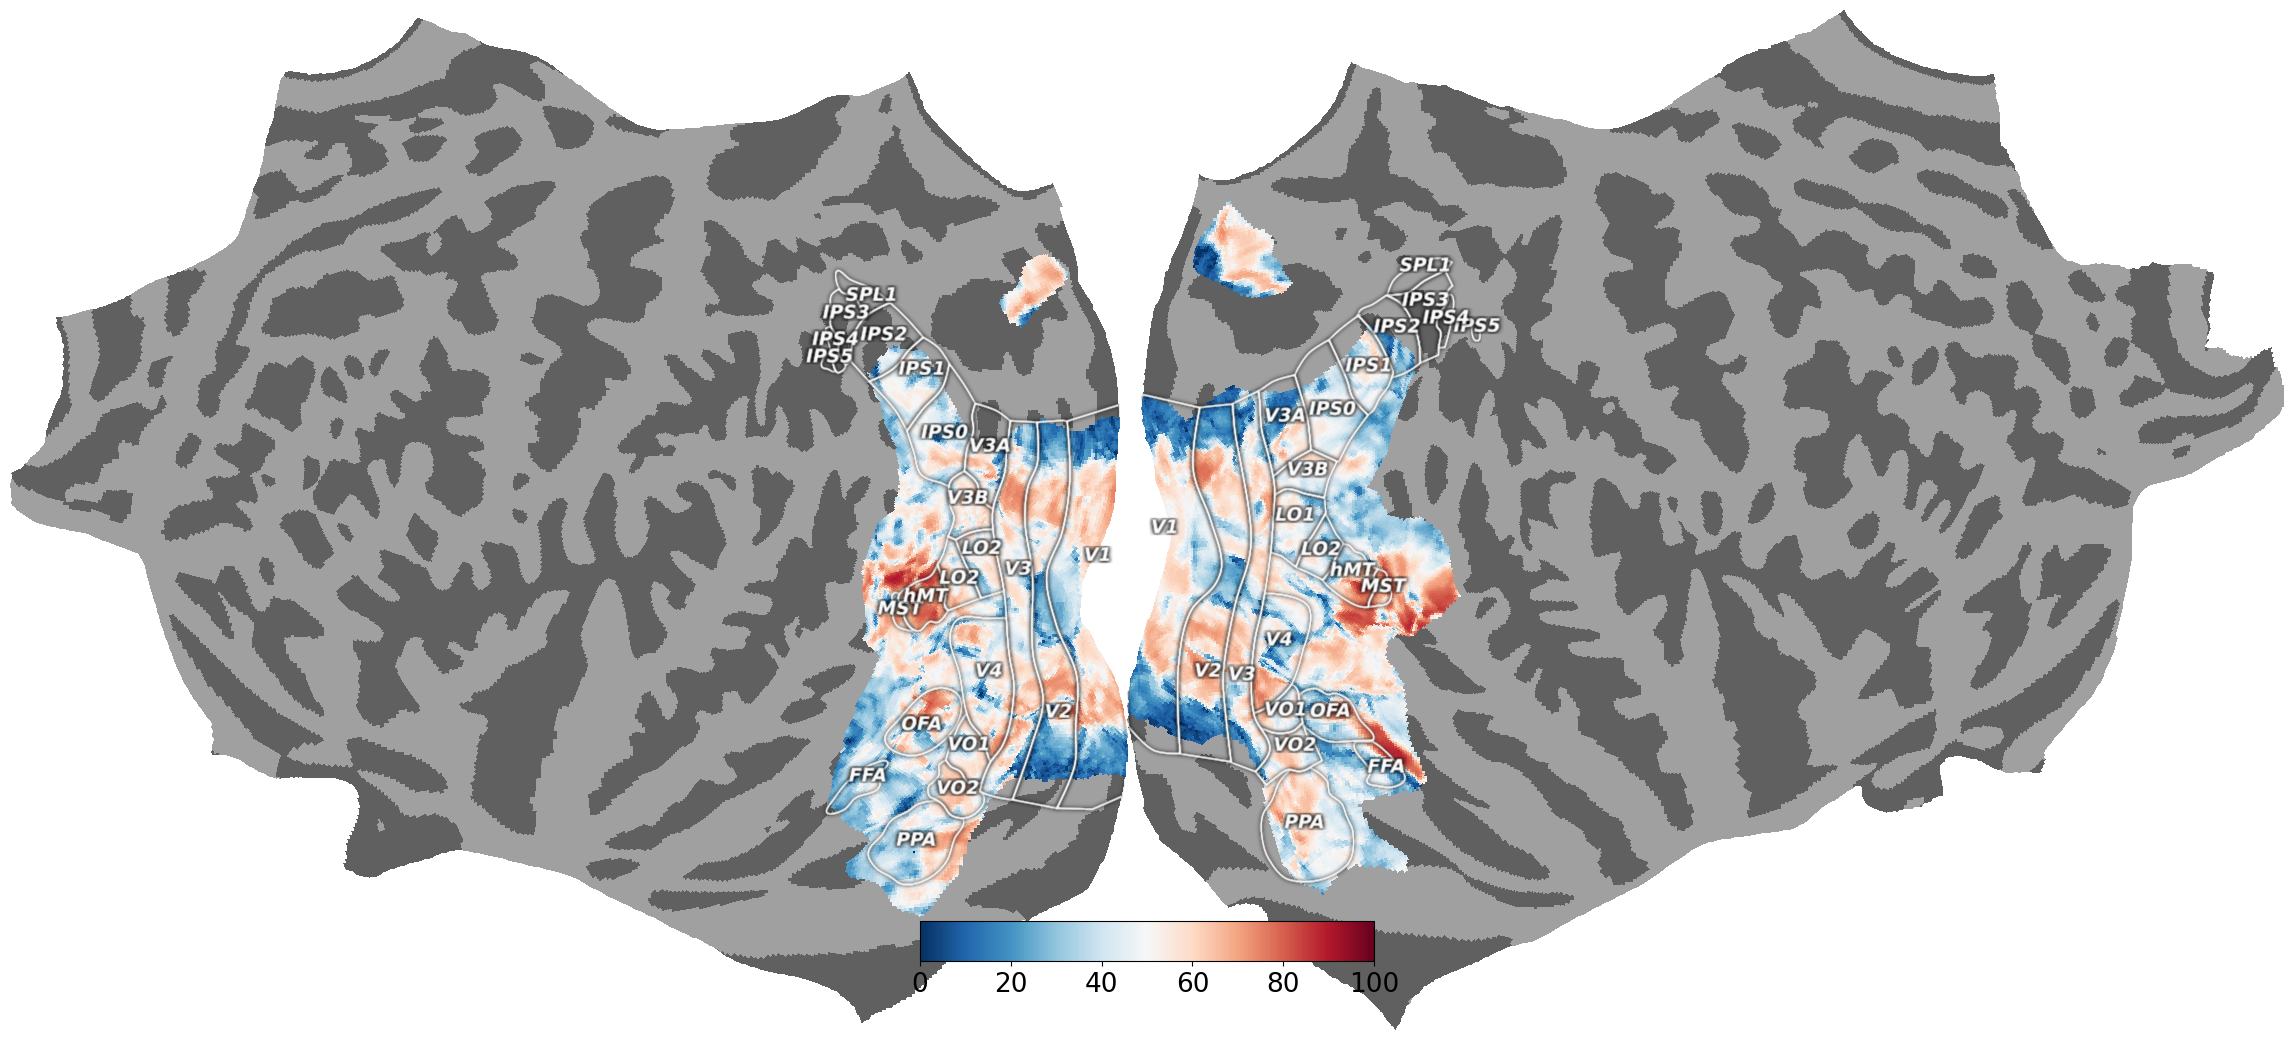

In [8]:
"""Plot data on a flattened brain surface using pycortex.

"""

import os
from copy import copy
import numpy as np
from matplotlib import pyplot as plt
import cortex
import cortex.polyutils


# =============================================================================
# Map the data to fsaverage space
# =============================================================================
# pycortex requires data in fsaverage space, so here you map the vertices from
# Challenge space into fsaverage space. The voxels not used in the Challenge
# are given NaN values, so that pycortex ignores them for the plotting.
# "ls_scores" and "rh_scores" are lists with 8 elements, one for each subject.
# These elements consist of vectors of length N, where N is the vertex amount
# for each subject and hemisphere, and each vector component consists of the
# prediction accuracy for that vertex.

#challenge_data_dir = '../algonauts_2023_challenge_data'
challenge_data_dir = '../../algonauts_2023_challenge_data/'
lh_fsaverage = []
rh_fsaverage = []
subjects = [1]
for s, sub in enumerate(subjects):
    lh_mask_dir = os.path.join(challenge_data_dir, 'subj'+format(sub, '02'),
        'roi_masks', 'lh.all-vertices_fsaverage_space.npy')
    rh_mask_dir = os.path.join(challenge_data_dir, 'subj'+format(sub, '02'),
        'roi_masks', 'rh.all-vertices_fsaverage_space.npy')
    lh_fsaverage_all_vertices = np.load(lh_mask_dir)
    rh_fsaverage_all_vertices = np.load(rh_mask_dir)
    lh_fsavg = np.empty((len(lh_fsaverage_all_vertices)))
    lh_fsavg[:] = np.nan
    lh_fsavg[np.where(lh_fsaverage_all_vertices)[0]] = lh_correlation #lh_scores[s]
    lh_fsaverage.append(copy(lh_fsavg))
    rh_fsavg = np.empty((len(rh_fsaverage_all_vertices)))
    rh_fsavg[:] = np.nan
    rh_fsavg[np.where(rh_fsaverage_all_vertices)[0]] = rh_correlation #rh_scores[s]
    rh_fsaverage.append(copy(rh_fsavg))
    
    break

# Average the scores across subjects
lh_fsaverage = np.nanmean(lh_fsaverage, 0)
rh_fsaverage = np.nanmean(rh_fsaverage, 0)


# =============================================================================
# Plot parameters for colorbar
# =============================================================================
plt.rc('xtick', labelsize=19)
plt.rc('ytick', labelsize=19)


# =============================================================================
# Plot the results on brain surfaces
# =============================================================================
subject = 'fsaverage'
data = np.append(lh_fsaverage, rh_fsaverage) * 100
vertex_data = cortex.Vertex(data, subject, cmap='RdBu_r', vmin=0, vmax=100)
cortex.quickshow(vertex_data, with_curvature=True)
plt.show()
